In [18]:
%matplotlib inline

In [19]:
import os
import io
import json
import tqdm
import shutil
import pprint
import pathlib
import tempfile
import requests
import collections
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from etils import epath
from IPython import display
from urllib.request import urlopen

In [20]:
import orbit
import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_datasets as tfds

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.data import tfrecord_lib
from official.vision.serving import export_saved_model_lib
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder
from official.vision.utils.object_detection import visualization_utils
from official.vision.ops.preprocess_ops import normalize_image, resize_and_crop_image
from official.vision.data.create_coco_tf_record import coco_annotations_to_lists
import random

In [33]:
EXPORT_DIR = "out/mask_rcnn_1720965776.3755596"
IMAGE_SIZE=(640, 640)
INPUT_PATH = "/home/stefan.steinheber/tensorflow_datasets/leaf_instance_dataset/1.0.0/"
CATEGORY_INDEX = {
    1: {
        'id': 1,
        'name': 'leaf'
    }
}
TEST_DIR = "_data/combined/test"
NUM_SAMPLES = 3

In [22]:
tf_ex_decoder = TfExampleDecoder(include_mask=True)

In [23]:
def show_batch(raw_records):
    plt.figure(figsize=(20, 20))
    use_normalized_coordinates=True
    min_score_thresh = 0.30
    for i, serialized_example in enumerate(raw_records):
        plt.subplot(1, 3, i + 1)
        decoded_tensors = tf_ex_decoder.decode(serialized_example)
        image = decoded_tensors['image'].numpy().astype('uint8')
        scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
        # print(decoded_tensors['groundtruth_instance_masks'].numpy().shape)
        # print(decoded_tensors.keys())
        visualization_utils.visualize_boxes_and_labels_on_image_array(
            image,
            decoded_tensors['groundtruth_boxes'].numpy(),
            decoded_tensors['groundtruth_classes'].numpy().astype('int'),
            scores,
            category_index=CATEGORY_INDEX,
            use_normalized_coordinates=use_normalized_coordinates,
            min_score_thresh=min_score_thresh,
            instance_masks=decoded_tensors['groundtruth_instance_masks'].numpy().astype('uint8'),
            line_thickness=4)

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image-{i+1}")
    plt.show()

In [24]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

In [25]:
def reframe_image_corners_relative_to_boxes(boxes):
  """Reframe the image corners ([0, 0, 1, 1]) to be relative to boxes.
  The local coordinate frame of each box is assumed to be relative to
  its own for corners.
  Args:
    boxes: A float tensor of [num_boxes, 4] of (ymin, xmin, ymax, xmax)
      coordinates in relative coordinate space of each bounding box.
  Returns:
    reframed_boxes: Reframes boxes with same shape as input.
  """
  ymin, xmin, ymax, xmax = (boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3])

  height = tf.maximum(ymax - ymin, 1e-4)
  width = tf.maximum(xmax - xmin, 1e-4)

  ymin_out = (0 - ymin) / height
  xmin_out = (0 - xmin) / width
  ymax_out = (1 - ymin) / height
  xmax_out = (1 - xmin) / width
  return tf.stack([ymin_out, xmin_out, ymax_out, xmax_out], axis=1)

def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                     image_width, resize_method='bilinear'):
  """Transforms the box masks back to full image masks.
  Embeds masks in bounding boxes of larger masks whose shapes correspond to
  image shape.
  Args:
    box_masks: A tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.
    resize_method: The resize method, either 'bilinear' or 'nearest'. Note that
      'bilinear' is only respected if box_masks is a float.
  Returns:
    A tensor of size [num_masks, image_height, image_width] with the same dtype
    as `box_masks`.
  """
  resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
  # TODO(rathodv): Make this a public function.
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""

    num_boxes = tf.shape(box_masks)[0]
    box_masks_expanded = tf.expand_dims(box_masks, axis=3)

    resized_crops = tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reframe_image_corners_relative_to_boxes(boxes),
        box_indices=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        method=resize_method,
        extrapolation_value=0)
    return tf.cast(resized_crops, box_masks.dtype)

  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
  return tf.squeeze(image_masks, axis=3)

In [34]:
imported = tf.saved_model.load(EXPORT_DIR)
model_fn = imported.signatures['serving_default']

In [48]:
test_files = [os.path.join(TEST_DIR, file) for file in os.listdir(TEST_DIR) if not file.startswith('.')]
test_files = random.sample(test_files, NUM_SAMPLES)
print(len(test_files))

3


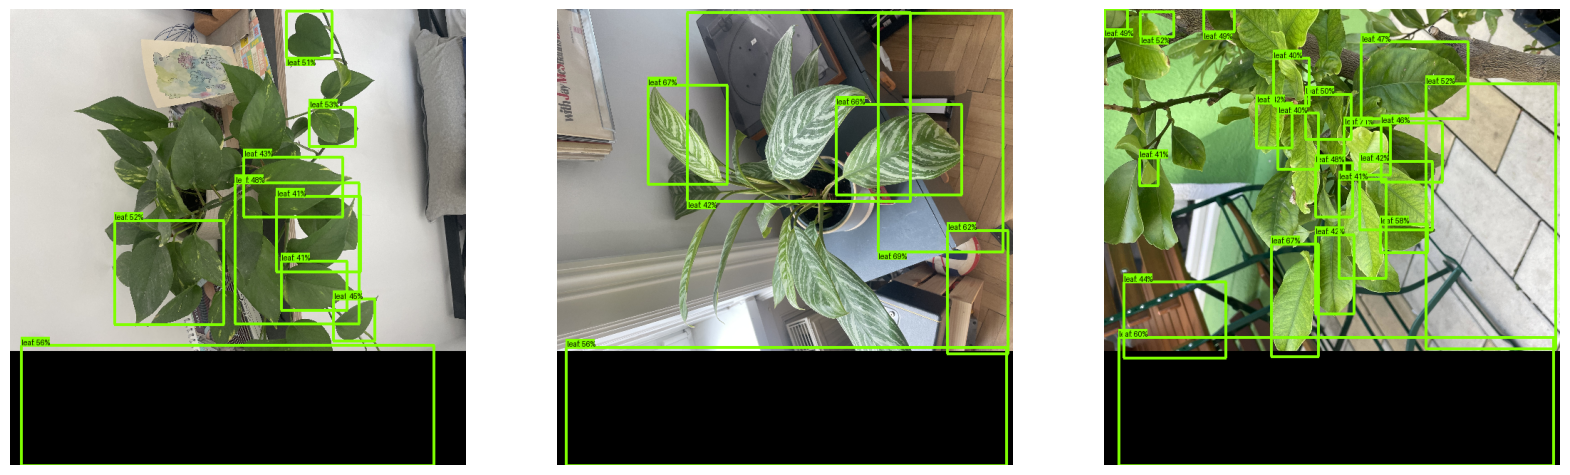

In [49]:
input_image_size = (IMAGE_SIZE[1], IMAGE_SIZE[0])
plt.figure(figsize=(20, 20))
min_score_thresh = 0.40 # Change minimum score for threshold to see all bounding boxes confidences

for i, file in enumerate(test_files):
    plt.subplot(1, 3, i+1)
    image = build_inputs_for_object_detection(Image.open(file), input_image_size)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, dtype = tf.uint8)
    image_np = image[0].numpy()
    result = model_fn(image)
    # Visualize detection and masks
    if 'detection_masks' in result:
        # we need to convert np.arrays to tensors
        detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
        detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])
        detection_masks_reframed = reframe_box_masks_to_image_masks(
                  detection_masks, detection_boxes/256.0,
                    image_np.shape[0], image_np.shape[1])
        detection_masks_reframed = tf.cast(
            detection_masks_reframed > min_score_thresh,
            np.uint8)
        result['detection_masks_reframed'] = detection_masks_reframed.numpy()
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        result['detection_boxes'][0].numpy(),
        (result['detection_classes'][0] + 0).numpy().astype(int),
        result['detection_scores'][0].numpy(),
        category_index=CATEGORY_INDEX,
        use_normalized_coordinates=False,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        instance_masks=result.get('detection_masks_reframed', None),
        line_thickness=4)

    plt.imshow(image_np)
    plt.axis("off")

plt.show()